<a href="https://colab.research.google.com/github/kdambrowski/Space_ship_titanic/blob/main/Spaceship_titanic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install ydata-profiling

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 344.9/344.9 KB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.7/102.7 KB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.8/33.8 MB 22.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 39.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 KB 7.1 MB/s eta 0:00:00
  Attempting uninstall: tqdm
    Found existing installation: tqdm 4.65.0
    Uninstalling tqdm-4.65.0:
      Successfully uninstalled tqdm-4.65.0
  Attempting uninstall: scipy
    Found existing installation: scipy 1.10.1
    Uninstalling scipy-1.10.1:
      Successfully uninstalled scipy-1.10.1
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.7.1
    Uninstalling matplotlib-3.7.1:
      Successfully uninstalled matplotlib-3.7.1
  Attempting uninstall: visions

In [80]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

import os
import shutil

from ydata_profiling import ProfileReport
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from scipy.stats import normaltest
from sklearn.model_selection import train_test_split, KFold
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score




In [3]:
# average:
#   None - wyniki dla każdej klasy osobno
#   'binary' - dla wybranej w `pos_label` etykiety
#   'micro' - dla całkowitej liczby TP, FN, FP
#   'macro' - nieważona średnia dla każdej klasy
#   'weighted' - ważona średnia dla każdej klasy

def calculate_metrics(target, prediction, average='macro'):
    accuracy = accuracy_score(target, prediction)
    precision = precision_score(target, prediction, average=average, zero_division=0)
    recall = recall_score(target, prediction, average=average, zero_division=0)
    f1 = f1_score(target, prediction, average=average, zero_division=0)
    mislabeled = (target != prediction).sum()
    total = len(target)
    return accuracy, precision, recall, f1, mislabeled, total

def print_results(metrics, classifier_id='classifier'):
    print(f'Results for {classifier_id}')
    print('----')
    print(f'  Accuracy:  {metrics[0]}')
    print(f'  Precision: {metrics[1]}')
    print(f'  Recall:    {metrics[2]}')
    print(f'  F1 score:  {metrics[3]}')
    print(f'  Mislabeled {metrics[4]} out of {metrics[5]}')
    print('\n')

def plot_confusion_matrix(confusion_matrix, classes, title=None,
                          title_appendix='',
                          cmap=plt.cm.Blues):
    # tytuł wykresu
    if title_appendix:
        title_appendix = f'({title_appendix})'
    # czeny ty nie ma else
    if title is None:
        title = f'Confusion matrix {title_appendix}'
    
    fig, ax = plt.subplots(figsize=(10,5))
    # rysuje CM
    img = ax.imshow(confusion_matrix, cmap=cmap)
    # dodaje pasek z boku .figure.colorbar(zmienna z wykresem, dane do wykresu)
    ax.figure.colorbar(img, ax=ax)
    # dodatki do wykresu
    ax.set_xticks(np.arange(confusion_matrix.shape[1]))
    ax.set_xticklabels(classes, rotation=45, ha='right', rotation_mode='anchor')
    ax.set_yticks(np.arange(confusion_matrix.shape[0]))
    ax.set_yticklabels(classes, rotation=45, ha='right', rotation_mode='anchor')
    ax.set_title(title)
    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')
    
    # etykiety
    fmt = '.2f' if confusion_matrix.dtype == 'float' else 'd'
    thresh = confusion_matrix.max() / 2
    for y, row in enumerate(confusion_matrix):
        for x, cell in enumerate(row):
            ax.text(x, y, format(cell, fmt),
                    ha='center', va='center',
                    color='white' if cell > thresh else 'black')
    fig.tight_layout()
    
    return ax

def normalize_confusion_matrix(confusion_matrix):
    return confusion_matrix.astype(
        'float') / confusion_matrix.sum(
        axis=1)[np.newaxis].T

In [4]:
space_titanic_test = pd.read_csv('/content/test_space_titanic.csv')
space_titanic_train = pd.read_csv('/content/train_space_titanic.csv')
space_titanic_sample = pd.read_csv('/content/sample_submission_space_titanic.csv')

In [5]:
space_titanic_train.head(20)

PassengerId HomePlanet CryoSleep  Cabin    Destination   Age    VIP  \
0      0001_01     Europa     False  B/0/P    TRAPPIST-1e  39.0  False   
1      0002_01      Earth     False  F/0/S    TRAPPIST-1e  24.0  False   
2      0003_01     Europa     False  A/0/S    TRAPPIST-1e  58.0   True   
3      0003_02     Europa     False  A/0/S    TRAPPIST-1e  33.0  False   
4      0004_01      Earth     False  F/1/S    TRAPPIST-1e  16.0  False   
5      0005_01      Earth     False  F/0/P  PSO J318.5-22  44.0  False   
6      0006_01      Earth     False  F/2/S    TRAPPIST-1e  26.0  False   
7      0006_02      Earth      True  G/0/S    TRAPPIST-1e  28.0  False   
8      0007_01      Earth     False  F/3/S    TRAPPIST-1e  35.0  False   
9      0008_01     Europa      True  B/1/P    55 Cancri e  14.0  False   
10     0008_02     Europa      True  B/1/P    TRAPPIST-1e  34.0  False   
11     0008_03     Europa     False  B/1/P    55 Cancri e  45.0  False   
12     0009_01       Mars     False  F/1/P    TRAPPIST-1e  32.0  False   
13     0010_01      Earth     False  G/1/S    TRAPPIST-1e  48.0  False   
14     0011_01      Earth     False  F/2/P    TRAPPIST-1e  28.0  False   
15     0012_01      Earth     False    NaN    TRAPPIST-1e  31.0  False   
16     0014_01       Mars     False  F/3/P    55 Cancri e  27.0  False   
17     0015_01      Earth     False  F/4/P    55 Cancri e  24.0  False   
18     0016_01       Mars      True  F/5/P    TRAPPIST-1e  45.0  False   
19     0017_01      Earth     False  G/0/P    TRAPPIST-1e   0.0  False   

    RoomService  FoodCourt  ShoppingMall     Spa  VRDeck                Name  \
0           0.0        0.0           0.0     0.0     0.0     Maham Ofracculy   
1         109.0        9.0          25.0   549.0    44.0        Juanna Vines   
2          43.0     3576.0           0.0  6715.0    49.0       Altark Susent   
3           0.0     1283.0         371.0  3329.0   193.0        Solam Susent   
4         303.0       70.0         151.0   565.0     2.0   Willy Santantines   
5           0.0      483.0           0.0   291.0     0.0   Sandie Hinetthews   
6          42.0     1539.0           3.0     0.0     0.0  Billex Jacostaffey   
7           0.0        0.0           0.0     0.0     NaN  Candra Jacostaffey   
8           0.0      785.0          17.0   216.0     0.0       Andona Beston   
9           0.0        0.0           0.0     0.0     0.0      Erraiam Flatic   
10          0.0        0.0           NaN     0.0     0.0      Altardr Flatic   
11         39.0     7295.0         589.0   110.0   124.0       Wezena Flatic   
12         73.0        0.0        1123.0     0.0   113.0        Berers Barne   
13        719.0        1.0          65.0     0.0    24.0      Reney Baketton   
14          8.0      974.0          12.0     2.0     7.0     Elle Bertsontry   
15         32.0        0.0         876.0     0.0     0.0       Justie Pooles   
16       1286.0      122.0           NaN     0.0     0.0         Flats Eccle   
17          0.0        1.0           0.0     0.0   637.0     Carry Hughriend   
18          0.0        0.0           0.0     0.0     0.0          Alus Upead   
19          0.0        0.0           0.0     0.0     0.0       Lyde Brighttt   

    Transported  
0         False  
1          True  
2         False  
3         False  
4          True  
5          True  
6          True  
7          True  
8          True  
9          True  
10         True  
11         True  
12         True  
13        False  
14         True  
15        False  
16        False  
17        False  
18         True  
19         True

In [6]:
space_titanic_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [7]:
space_titanic_train

PassengerId HomePlanet CryoSleep     Cabin    Destination   Age    VIP  \
0        0001_01     Europa     False     B/0/P    TRAPPIST-1e  39.0  False   
1        0002_01      Earth     False     F/0/S    TRAPPIST-1e  24.0  False   
2        0003_01     Europa     False     A/0/S    TRAPPIST-1e  58.0   True   
3        0003_02     Europa     False     A/0/S    TRAPPIST-1e  33.0  False   
4        0004_01      Earth     False     F/1/S    TRAPPIST-1e  16.0  False   
...          ...        ...       ...       ...            ...   ...    ...   
8688     9276_01     Europa     False    A/98/P    55 Cancri e  41.0   True   
8689     9278_01      Earth      True  G/1499/S  PSO J318.5-22  18.0  False   
8690     9279_01      Earth     False  G/1500/S    TRAPPIST-1e  26.0  False   
8691     9280_01     Europa     False   E/608/S    55 Cancri e  32.0  False   
8692     9280_02     Europa     False   E/608/S    TRAPPIST-1e  44.0  False   

      RoomService  FoodCourt  ShoppingMall     Spa  VRDeck               Name  \
0             0.0        0.0           0.0     0.0     0.0    Maham Ofracculy   
1           109.0        9.0          25.0   549.0    44.0       Juanna Vines   
2            43.0     3576.0           0.0  6715.0    49.0      Altark Susent   
3             0.0     1283.0         371.0  3329.0   193.0       Solam Susent   
4           303.0       70.0         151.0   565.0     2.0  Willy Santantines   
...           ...        ...           ...     ...     ...                ...   
8688          0.0     6819.0           0.0  1643.0    74.0  Gravior Noxnuther   
8689          0.0        0.0           0.0     0.0     0.0    Kurta Mondalley   
8690          0.0        0.0        1872.0     1.0     0.0       Fayey Connon   
8691          0.0     1049.0           0.0   353.0  3235.0   Celeon Hontichre   
8692        126.0     4688.0           0.0     0.0    12.0   Propsh Hontichre   

      Transported  
0           False  
1            True  
2           False  
3           False  
4            True  
...           ...  
8688        False  
8689        False  
8690         True  
8691        False  
8692         True  

[8693 rows x 14 columns]

In [8]:
space_titanic_train.isnull().sum().sort_values()

PassengerId       0
Transported       0
Age             179
RoomService     181
Destination     182
FoodCourt       183
Spa             183
VRDeck          188
Cabin           199
Name            200
HomePlanet      201
VIP             203
ShoppingMall    208
CryoSleep       217
dtype: int64

In [9]:
is_null_filter = space_titanic_train.isnull().sum(axis=1).astype(bool)
space_titanic_train_wo_null = space_titanic_train[~is_null_filter]
space_titanic_train_wo_null.isnull().sum()

PassengerId     0
HomePlanet      0
CryoSleep       0
Cabin           0
Destination     0
Age             0
VIP             0
RoomService     0
FoodCourt       0
ShoppingMall    0
Spa             0
VRDeck          0
Name            0
Transported     0
dtype: int64

In [10]:
space_titanic_train[~is_null_filter].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6606 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   6606 non-null   object 
 1   HomePlanet    6606 non-null   object 
 2   CryoSleep     6606 non-null   object 
 3   Cabin         6606 non-null   object 
 4   Destination   6606 non-null   object 
 5   Age           6606 non-null   float64
 6   VIP           6606 non-null   object 
 7   RoomService   6606 non-null   float64
 8   FoodCourt     6606 non-null   float64
 9   ShoppingMall  6606 non-null   float64
 10  Spa           6606 non-null   float64
 11  VRDeck        6606 non-null   float64
 12  Name          6606 non-null   object 
 13  Transported   6606 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 729.0+ KB


In [11]:
non_num_col = space_titanic_train_wo_null.select_dtypes(['object'])

In [12]:
space_titanic_train_wo_null['Age'].value_counts(sort=True)

24.0    255
18.0    255
22.0    234
21.0    227
19.0    225
       ... 
72.0      3
79.0      2
75.0      2
76.0      2
77.0      1
Name: Age, Length: 80, dtype: int64

In [13]:
a = non_num_col[['CryoSleep']].value_counts(sort=True)
a
# a.sum()

CryoSleep
False        4274
True         2332
dtype: int64

In [14]:
np.array(non_num_col['HomePlanet'].value_counts().index)[:10]

array(['Earth', 'Europa', 'Mars'], dtype=object)

<BarContainer object of 3 artists>

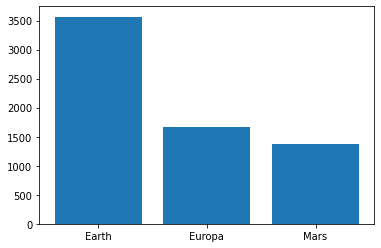

In [15]:
count = []
non_num_col['HomePlanet'].value_counts()
np.array(non_num_col['HomePlanet'].value_counts())
np.array(non_num_col['HomePlanet'].value_counts().index)
plt.bar(np.array(non_num_col['HomePlanet'].value_counts().index)[:10], np.array(non_num_col['HomePlanet'].value_counts()))

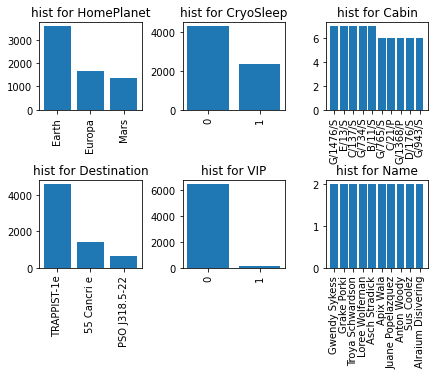

In [16]:
i = 0
for col in non_num_col.columns:
  if (non_num_col[[col]].value_counts()>1).sum()>0:

    ax = plt.subplot(3,3,i+1)
    plt.bar(np.array(non_num_col[col].value_counts(sort=True).index)[:10], 
    np.array(non_num_col[col].value_counts())[:10])
    plt.title(f'hist for {col}')
    plt.subplots_adjust(left=0.1,
                      bottom=0.1,
                      right=1,
                      top=1.5,
                      wspace=0.4,
                      hspace=0.8)
    plt.xticks(rotation=90)
    i = i+1
    


In [17]:
space_titanic_train_wo_null.describe()

Age  RoomService     FoodCourt  ShoppingMall           Spa  \
count  6606.000000  6606.000000   6606.000000   6606.000000   6606.000000   
mean     28.894036   222.991674    478.958523    178.356494    313.161520   
std      14.533429   644.987936   1678.592291    576.328407   1144.016291   
min       0.000000     0.000000      0.000000      0.000000      0.000000   
25%      19.000000     0.000000      0.000000      0.000000      0.000000   
50%      27.000000     0.000000      0.000000      0.000000      0.000000   
75%      38.000000    49.000000     82.750000     30.000000     65.000000   
max      79.000000  9920.000000  29813.000000  12253.000000  22408.000000   

             VRDeck  
count   6606.000000  
mean     303.780048  
std     1127.142166  
min        0.000000  
25%        0.000000  
50%        0.000000  
75%       52.000000  
max    20336.000000

In [18]:
value_col = space_titanic_train_wo_null.select_dtypes(['float64'])

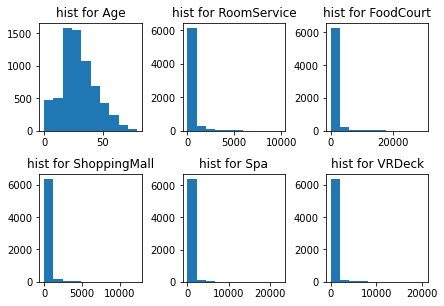

In [19]:
i=0
for col in value_col.columns:
  ax = plt.subplot(2,3,i+1)
  plt.hist(value_col[col])
  plt.title(f'hist for {col}')
  plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=1,
                    top=1,
                    wspace=0.4,
                    hspace=0.4)
  i = i+1

In [20]:
space_titanic_train_wo_null['Age'][space_titanic_train_wo_null['Age'].between(0,1)].value_counts()

0.0    140
1.0     54
Name: Age, dtype: int64

In [21]:
# space_titanic_train['null_row'] = space_titanic_train.isnull().sum().astype(bool)
# space_titanic_train.columns

In [22]:
space_titanic_train_wo_null_age_clearing = space_titanic_train_wo_null['Age']>0
space_titanic_train_wo_null_age_clearing =space_titanic_train_wo_null[space_titanic_train_wo_null_age_clearing]

In [23]:
pd_profile_train = ProfileReport(space_titanic_train, title="Profiling Report")

#Pd profiling

In [24]:
pd_profile_train.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [25]:
X_train = pd.DataFrame(space_titanic_train_wo_null_age_clearing)
y_train = X_train.loc[:,'Transported'].astype(float)
X_train = X_train.drop(columns ='Transported')
y_train

0       0.0
1       1.0
2       0.0
3       0.0
4       1.0
       ... 
8688    0.0
8689    0.0
8690    1.0
8691    0.0
8692    1.0
Name: Transported, Length: 6466, dtype: float64

In [26]:
y_train.value_counts()

0.0    3255
1.0    3211
Name: Transported, dtype: int64

In [27]:
space_titanic_test.head(2)

PassengerId HomePlanet CryoSleep  Cabin  Destination   Age    VIP  \
0     0013_01      Earth      True  G/3/S  TRAPPIST-1e  27.0  False   
1     0018_01      Earth     False  F/4/S  TRAPPIST-1e  19.0  False   

   RoomService  FoodCourt  ShoppingMall     Spa  VRDeck             Name  
0          0.0        0.0           0.0     0.0     0.0  Nelly Carsoning  
1          0.0        9.0           0.0  2823.0     0.0   Lerome Peckers

In [28]:
space_titanic_train.describe()

Age   RoomService     FoodCourt  ShoppingMall           Spa  \
count  8514.000000   8512.000000   8510.000000   8485.000000   8510.000000   
mean     28.827930    224.687617    458.077203    173.729169    311.138778   
std      14.489021    666.717663   1611.489240    604.696458   1136.705535   
min       0.000000      0.000000      0.000000      0.000000      0.000000   
25%      19.000000      0.000000      0.000000      0.000000      0.000000   
50%      27.000000      0.000000      0.000000      0.000000      0.000000   
75%      38.000000     47.000000     76.000000     27.000000     59.000000   
max      79.000000  14327.000000  29813.000000  23492.000000  22408.000000   

             VRDeck  
count   8505.000000  
mean     304.854791  
std     1145.717189  
min        0.000000  
25%        0.000000  
50%        0.000000  
75%       46.000000  
max    24133.000000

In [29]:
space_titanic_test.describe()

Age   RoomService     FoodCourt  ShoppingMall           Spa  \
count  4186.000000   4195.000000   4171.000000   4179.000000   4176.000000   
mean     28.658146    219.266269    439.484296    177.295525    303.052443   
std      14.179072    607.011289   1527.663045    560.821123   1117.186015   
min       0.000000      0.000000      0.000000      0.000000      0.000000   
25%      19.000000      0.000000      0.000000      0.000000      0.000000   
50%      26.000000      0.000000      0.000000      0.000000      0.000000   
75%      37.000000     53.000000     78.000000     33.000000     50.000000   
max      79.000000  11567.000000  25273.000000   8292.000000  19844.000000   

             VRDeck  
count   4197.000000  
mean     310.710031  
std     1246.994742  
min        0.000000  
25%        0.000000  
50%        0.000000  
75%       36.000000  
max    22272.000000

In [30]:
space_titanic_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   4277 non-null   object 
 1   HomePlanet    4190 non-null   object 
 2   CryoSleep     4184 non-null   object 
 3   Cabin         4177 non-null   object 
 4   Destination   4185 non-null   object 
 5   Age           4186 non-null   float64
 6   VIP           4184 non-null   object 
 7   RoomService   4195 non-null   float64
 8   FoodCourt     4171 non-null   float64
 9   ShoppingMall  4179 non-null   float64
 10  Spa           4176 non-null   float64
 11  VRDeck        4197 non-null   float64
 12  Name          4183 non-null   object 
dtypes: float64(6), object(7)
memory usage: 434.5+ KB


In [31]:
space_titanic_test.isnull().sum().sort_values()

PassengerId       0
VRDeck           80
RoomService      82
HomePlanet       87
Age              91
Destination      92
CryoSleep        93
VIP              93
Name             94
ShoppingMall     98
Cabin           100
Spa             101
FoodCourt       106
dtype: int64

In [32]:
space_titanic_test_wo_null = space_titanic_test[~space_titanic_test.isnull()]

In [33]:
space_titanic_test_wo_null

PassengerId HomePlanet CryoSleep     Cabin    Destination   Age    VIP  \
0        0013_01      Earth      True     G/3/S    TRAPPIST-1e  27.0  False   
1        0018_01      Earth     False     F/4/S    TRAPPIST-1e  19.0  False   
2        0019_01     Europa      True     C/0/S    55 Cancri e  31.0  False   
3        0021_01     Europa     False     C/1/S    TRAPPIST-1e  38.0  False   
4        0023_01      Earth     False     F/5/S    TRAPPIST-1e  20.0  False   
...          ...        ...       ...       ...            ...   ...    ...   
4272     9266_02      Earth      True  G/1496/S    TRAPPIST-1e  34.0  False   
4273     9269_01      Earth     False       NaN    TRAPPIST-1e  42.0  False   
4274     9271_01       Mars      True   D/296/P    55 Cancri e   NaN  False   
4275     9273_01     Europa     False   D/297/P            NaN   NaN  False   
4276     9277_01      Earth      True  G/1498/S  PSO J318.5-22  43.0  False   

      RoomService  FoodCourt  ShoppingMall     Spa  VRDeck              Name  
0             0.0        0.0           0.0     0.0     0.0   Nelly Carsoning  
1             0.0        9.0           0.0  2823.0     0.0    Lerome Peckers  
2             0.0        0.0           0.0     0.0     0.0   Sabih Unhearfus  
3             0.0     6652.0           0.0   181.0   585.0  Meratz Caltilter  
4            10.0        0.0         635.0     0.0     0.0   Brence Harperez  
...           ...        ...           ...     ...     ...               ...  
4272          0.0        0.0           0.0     0.0     0.0       Jeron Peter  
4273          0.0      847.0          17.0    10.0   144.0     Matty Scheron  
4274          0.0        0.0           0.0     0.0     0.0       Jayrin Pore  
4275          0.0     2680.0           0.0     0.0   523.0    Kitakan Conale  
4276          0.0        0.0           0.0     0.0     0.0  Lilace Leonzaley  

[4277 rows x 13 columns]

In [34]:
space_titanic_sample

PassengerId  Transported
0        0013_01        False
1        0018_01        False
2        0019_01        False
3        0021_01        False
4        0023_01        False
...          ...          ...
4272     9266_02        False
4273     9269_01        False
4274     9271_01        False
4275     9273_01        False
4276     9277_01        False

[4277 rows x 2 columns]

In [35]:
space_titanic_sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   PassengerId  4277 non-null   object
 1   Transported  4277 non-null   bool  
dtypes: bool(1), object(1)
memory usage: 37.7+ KB


In [36]:
space_titanic_sample['Transported'].value_counts()

False    4277
Name: Transported, dtype: int64

In [37]:
merged_test_and_sample_DF = pd.merge(left=space_titanic_test_wo_null,
         right=space_titanic_sample)

In [38]:
merged_test_and_sample_DF

PassengerId HomePlanet CryoSleep     Cabin    Destination   Age    VIP  \
0        0013_01      Earth      True     G/3/S    TRAPPIST-1e  27.0  False   
1        0018_01      Earth     False     F/4/S    TRAPPIST-1e  19.0  False   
2        0019_01     Europa      True     C/0/S    55 Cancri e  31.0  False   
3        0021_01     Europa     False     C/1/S    TRAPPIST-1e  38.0  False   
4        0023_01      Earth     False     F/5/S    TRAPPIST-1e  20.0  False   
...          ...        ...       ...       ...            ...   ...    ...   
4272     9266_02      Earth      True  G/1496/S    TRAPPIST-1e  34.0  False   
4273     9269_01      Earth     False       NaN    TRAPPIST-1e  42.0  False   
4274     9271_01       Mars      True   D/296/P    55 Cancri e   NaN  False   
4275     9273_01     Europa     False   D/297/P            NaN   NaN  False   
4276     9277_01      Earth      True  G/1498/S  PSO J318.5-22  43.0  False   

      RoomService  FoodCourt  ShoppingMall     Spa  VRDeck              Name  \
0             0.0        0.0           0.0     0.0     0.0   Nelly Carsoning   
1             0.0        9.0           0.0  2823.0     0.0    Lerome Peckers   
2             0.0        0.0           0.0     0.0     0.0   Sabih Unhearfus   
3             0.0     6652.0           0.0   181.0   585.0  Meratz Caltilter   
4            10.0        0.0         635.0     0.0     0.0   Brence Harperez   
...           ...        ...           ...     ...     ...               ...   
4272          0.0        0.0           0.0     0.0     0.0       Jeron Peter   
4273          0.0      847.0          17.0    10.0   144.0     Matty Scheron   
4274          0.0        0.0           0.0     0.0     0.0       Jayrin Pore   
4275          0.0     2680.0           0.0     0.0   523.0    Kitakan Conale   
4276          0.0        0.0           0.0     0.0     0.0  Lilace Leonzaley   

      Transported  
0           False  
1           False  
2           False  
3           False  
4           False  
...           ...  
4272        False  
4273        False  
4274        False  
4275        False  
4276        False  

[4277 rows x 14 columns]

In [39]:
pd_profiler_test_merged = ProfileReport(merged_test_and_sample_DF, title = 'TEST profiler')
pd_profiler_test_merged.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

# Modeling in case where test file will be trully values not sample 

In [40]:
merged_all_DS = pd.concat([merged_test_and_sample_DF,
                           space_titanic_train_wo_null_age_clearing],
                           join='inner')
merged_all_DS

PassengerId HomePlanet CryoSleep     Cabin    Destination   Age    VIP  \
0        0013_01      Earth      True     G/3/S    TRAPPIST-1e  27.0  False   
1        0018_01      Earth     False     F/4/S    TRAPPIST-1e  19.0  False   
2        0019_01     Europa      True     C/0/S    55 Cancri e  31.0  False   
3        0021_01     Europa     False     C/1/S    TRAPPIST-1e  38.0  False   
4        0023_01      Earth     False     F/5/S    TRAPPIST-1e  20.0  False   
...          ...        ...       ...       ...            ...   ...    ...   
8688     9276_01     Europa     False    A/98/P    55 Cancri e  41.0   True   
8689     9278_01      Earth      True  G/1499/S  PSO J318.5-22  18.0  False   
8690     9279_01      Earth     False  G/1500/S    TRAPPIST-1e  26.0  False   
8691     9280_01     Europa     False   E/608/S    55 Cancri e  32.0  False   
8692     9280_02     Europa     False   E/608/S    TRAPPIST-1e  44.0  False   

      RoomService  FoodCourt  ShoppingMall     Spa  VRDeck               Name  \
0             0.0        0.0           0.0     0.0     0.0    Nelly Carsoning   
1             0.0        9.0           0.0  2823.0     0.0     Lerome Peckers   
2             0.0        0.0           0.0     0.0     0.0    Sabih Unhearfus   
3             0.0     6652.0           0.0   181.0   585.0   Meratz Caltilter   
4            10.0        0.0         635.0     0.0     0.0    Brence Harperez   
...           ...        ...           ...     ...     ...                ...   
8688          0.0     6819.0           0.0  1643.0    74.0  Gravior Noxnuther   
8689          0.0        0.0           0.0     0.0     0.0    Kurta Mondalley   
8690          0.0        0.0        1872.0     1.0     0.0       Fayey Connon   
8691          0.0     1049.0           0.0   353.0  3235.0   Celeon Hontichre   
8692        126.0     4688.0           0.0     0.0    12.0   Propsh Hontichre   

      Transported  
0           False  
1           False  
2           False  
3           False  
4           False  
...           ...  
8688        False  
8689        False  
8690         True  
8691        False  
8692         True  

[10743 rows x 14 columns]

In [41]:
merged_all_DS.reset_index(drop=True)

PassengerId HomePlanet CryoSleep     Cabin    Destination   Age    VIP  \
0         0013_01      Earth      True     G/3/S    TRAPPIST-1e  27.0  False   
1         0018_01      Earth     False     F/4/S    TRAPPIST-1e  19.0  False   
2         0019_01     Europa      True     C/0/S    55 Cancri e  31.0  False   
3         0021_01     Europa     False     C/1/S    TRAPPIST-1e  38.0  False   
4         0023_01      Earth     False     F/5/S    TRAPPIST-1e  20.0  False   
...           ...        ...       ...       ...            ...   ...    ...   
10738     9276_01     Europa     False    A/98/P    55 Cancri e  41.0   True   
10739     9278_01      Earth      True  G/1499/S  PSO J318.5-22  18.0  False   
10740     9279_01      Earth     False  G/1500/S    TRAPPIST-1e  26.0  False   
10741     9280_01     Europa     False   E/608/S    55 Cancri e  32.0  False   
10742     9280_02     Europa     False   E/608/S    TRAPPIST-1e  44.0  False   

       RoomService  FoodCourt  ShoppingMall     Spa  VRDeck  \
0              0.0        0.0           0.0     0.0     0.0   
1              0.0        9.0           0.0  2823.0     0.0   
2              0.0        0.0           0.0     0.0     0.0   
3              0.0     6652.0           0.0   181.0   585.0   
4             10.0        0.0         635.0     0.0     0.0   
...            ...        ...           ...     ...     ...   
10738          0.0     6819.0           0.0  1643.0    74.0   
10739          0.0        0.0           0.0     0.0     0.0   
10740          0.0        0.0        1872.0     1.0     0.0   
10741          0.0     1049.0           0.0   353.0  3235.0   
10742        126.0     4688.0           0.0     0.0    12.0   

                    Name  Transported  
0        Nelly Carsoning        False  
1         Lerome Peckers        False  
2        Sabih Unhearfus        False  
3       Meratz Caltilter        False  
4        Brence Harperez        False  
...                  ...          ...  
10738  Gravior Noxnuther        False  
10739    Kurta Mondalley        False  
10740       Fayey Connon         True  
10741   Celeon Hontichre        False  
10742   Propsh Hontichre         True  

[10743 rows x 14 columns]

In [42]:
merged_all_DS.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10743 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   10743 non-null  object 
 1   HomePlanet    10656 non-null  object 
 2   CryoSleep     10650 non-null  object 
 3   Cabin         10643 non-null  object 
 4   Destination   10651 non-null  object 
 5   Age           10652 non-null  float64
 6   VIP           10650 non-null  object 
 7   RoomService   10661 non-null  float64
 8   FoodCourt     10637 non-null  float64
 9   ShoppingMall  10645 non-null  float64
 10  Spa           10642 non-null  float64
 11  VRDeck        10663 non-null  float64
 12  Name          10649 non-null  object 
 13  Transported   10743 non-null  bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 1.2+ MB


In [43]:
merged_all_DS_null = merged_all_DS.isnull().sum(axis=1).astype(bool)
merged_all_DS = merged_all_DS[~merged_all_DS_null]

In [44]:
merged_all_DS.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9747 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   9747 non-null   object 
 1   HomePlanet    9747 non-null   object 
 2   CryoSleep     9747 non-null   object 
 3   Cabin         9747 non-null   object 
 4   Destination   9747 non-null   object 
 5   Age           9747 non-null   float64
 6   VIP           9747 non-null   object 
 7   RoomService   9747 non-null   float64
 8   FoodCourt     9747 non-null   float64
 9   ShoppingMall  9747 non-null   float64
 10  Spa           9747 non-null   float64
 11  VRDeck        9747 non-null   float64
 12  Name          9747 non-null   object 
 13  Transported   9747 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 1.1+ MB


In [45]:
merged_all_DS['HomePlanet'].value_counts().size

3

In [46]:
for col in merged_all_DS.columns:
  if merged_all_DS[col].value_counts().size<3:
     merged_all_DS[col] = merged_all_DS[col].astype('category').cat.codes

<ipython-input-46-e691680664ab>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_all_DS[col] = merged_all_DS[col].astype('category').cat.codes
<ipython-input-46-e691680664ab>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_all_DS[col] = merged_all_DS[col].astype('category').cat.codes
<ipython-input-46-e691680664ab>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

In [47]:
merged_all_DS.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9747 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   9747 non-null   object 
 1   HomePlanet    9747 non-null   object 
 2   CryoSleep     9747 non-null   int8   
 3   Cabin         9747 non-null   object 
 4   Destination   9747 non-null   object 
 5   Age           9747 non-null   float64
 6   VIP           9747 non-null   int8   
 7   RoomService   9747 non-null   float64
 8   FoodCourt     9747 non-null   float64
 9   ShoppingMall  9747 non-null   float64
 10  Spa           9747 non-null   float64
 11  VRDeck        9747 non-null   float64
 12  Name          9747 non-null   object 
 13  Transported   9747 non-null   int8   
dtypes: float64(6), int8(3), object(5)
memory usage: 942.3+ KB


In [48]:
a = pd.get_dummies(merged_all_DS,columns=['HomePlanet'])
a = pd.get_dummies(a,columns=['Destination'])
a

PassengerId  CryoSleep     Cabin   Age  VIP  RoomService  FoodCourt  \
0        0013_01          1     G/3/S  27.0    0          0.0        0.0   
1        0018_01          0     F/4/S  19.0    0          0.0        9.0   
2        0019_01          1     C/0/S  31.0    0          0.0        0.0   
3        0021_01          0     C/1/S  38.0    0          0.0     6652.0   
4        0023_01          0     F/5/S  20.0    0         10.0        0.0   
...          ...        ...       ...   ...  ...          ...        ...   
8688     9276_01          0    A/98/P  41.0    1          0.0     6819.0   
8689     9278_01          1  G/1499/S  18.0    0          0.0        0.0   
8690     9279_01          0  G/1500/S  26.0    0          0.0        0.0   
8691     9280_01          0   E/608/S  32.0    0          0.0     1049.0   
8692     9280_02          0   E/608/S  44.0    0        126.0     4688.0   

      ShoppingMall     Spa  VRDeck               Name  Transported  \
0              0.0     0.0     0.0    Nelly Carsoning            0   
1              0.0  2823.0     0.0     Lerome Peckers            0   
2              0.0     0.0     0.0    Sabih Unhearfus            0   
3              0.0   181.0   585.0   Meratz Caltilter            0   
4            635.0     0.0     0.0    Brence Harperez            0   
...            ...     ...     ...                ...          ...   
8688           0.0  1643.0    74.0  Gravior Noxnuther            0   
8689           0.0     0.0     0.0    Kurta Mondalley            0   
8690        1872.0     1.0     0.0       Fayey Connon            1   
8691           0.0   353.0  3235.0   Celeon Hontichre            0   
8692           0.0     0.0    12.0   Propsh Hontichre            1   

      HomePlanet_Earth  HomePlanet_Europa  HomePlanet_Mars  \
0                    1                  0                0   
1                    1                  0                0   
2                    0                  1                0   
3                    0                  1                0   
4                    1                  0                0   
...                ...                ...              ...   
8688                 0                  1                0   
8689                 1                  0                0   
8690                 1                  0                0   
8691                 0                  1                0   
8692                 0                  1                0   

      Destination_55 Cancri e  Destination_PSO J318.5-22  \
0                           0                          0   
1                           0                          0   
2                           1                          0   
3                           0                          0   
4                           0                          0   
...                       ...                        ...   
8688                        1                          0   
8689                        0                          1   
8690                        0                          0   
8691                        1                          0   
8692                        0                          0   

      Destination_TRAPPIST-1e  
0                           1  
1                           1  
2                           0  
3                           1  
4                           1  
...                       ...  
8688                        0  
8689                        0  
8690                        1  
8691                        0  
8692                        1  

[9747 rows x 18 columns]

In [49]:
merged_all_DS.columns[:-1]

Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age',
       'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Name'],
      dtype='object')

In [50]:
ohe_col = []
for col in merged_all_DS.columns[:-1]:
  if 2 < merged_all_DS[col].value_counts().size < 5:
    ohe_col.append(col)
    print(ohe_col)

merged_all_DS_ohe_df = pd.get_dummies(merged_all_DS,
                   columns=ohe_col
                   )
merged_all_DS_ohe_df

['HomePlanet']
['HomePlanet', 'Destination']


PassengerId  CryoSleep     Cabin   Age  VIP  RoomService  FoodCourt  \
0        0013_01          1     G/3/S  27.0    0          0.0        0.0   
1        0018_01          0     F/4/S  19.0    0          0.0        9.0   
2        0019_01          1     C/0/S  31.0    0          0.0        0.0   
3        0021_01          0     C/1/S  38.0    0          0.0     6652.0   
4        0023_01          0     F/5/S  20.0    0         10.0        0.0   
...          ...        ...       ...   ...  ...          ...        ...   
8688     9276_01          0    A/98/P  41.0    1          0.0     6819.0   
8689     9278_01          1  G/1499/S  18.0    0          0.0        0.0   
8690     9279_01          0  G/1500/S  26.0    0          0.0        0.0   
8691     9280_01          0   E/608/S  32.0    0          0.0     1049.0   
8692     9280_02          0   E/608/S  44.0    0        126.0     4688.0   

      ShoppingMall     Spa  VRDeck               Name  Transported  \
0              0.0     0.0     0.0    Nelly Carsoning            0   
1              0.0  2823.0     0.0     Lerome Peckers            0   
2              0.0     0.0     0.0    Sabih Unhearfus            0   
3              0.0   181.0   585.0   Meratz Caltilter            0   
4            635.0     0.0     0.0    Brence Harperez            0   
...            ...     ...     ...                ...          ...   
8688           0.0  1643.0    74.0  Gravior Noxnuther            0   
8689           0.0     0.0     0.0    Kurta Mondalley            0   
8690        1872.0     1.0     0.0       Fayey Connon            1   
8691           0.0   353.0  3235.0   Celeon Hontichre            0   
8692           0.0     0.0    12.0   Propsh Hontichre            1   

      HomePlanet_Earth  HomePlanet_Europa  HomePlanet_Mars  \
0                    1                  0                0   
1                    1                  0                0   
2                    0                  1                0   
3                    0                  1                0   
4                    1                  0                0   
...                ...                ...              ...   
8688                 0                  1                0   
8689                 1                  0                0   
8690                 1                  0                0   
8691                 0                  1                0   
8692                 0                  1                0   

      Destination_55 Cancri e  Destination_PSO J318.5-22  \
0                           0                          0   
1                           0                          0   
2                           1                          0   
3                           0                          0   
4                           0                          0   
...                       ...                        ...   
8688                        1                          0   
8689                        0                          1   
8690                        0                          0   
8691                        1                          0   
8692                        0                          0   

      Destination_TRAPPIST-1e  
0                           1  
1                           1  
2                           0  
3                           1  
4                           1  
...                       ...  
8688                        0  
8689                        0  
8690                        1  
8691                        0  
8692                        1  

[9747 rows x 18 columns]

In [51]:
merged_all_DS_ohe_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9747 entries, 0 to 8692
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   PassengerId                9747 non-null   object 
 1   CryoSleep                  9747 non-null   int8   
 2   Cabin                      9747 non-null   object 
 3   Age                        9747 non-null   float64
 4   VIP                        9747 non-null   int8   
 5   RoomService                9747 non-null   float64
 6   FoodCourt                  9747 non-null   float64
 7   ShoppingMall               9747 non-null   float64
 8   Spa                        9747 non-null   float64
 9   VRDeck                     9747 non-null   float64
 10  Name                       9747 non-null   object 
 11  Transported                9747 non-null   int8   
 12  HomePlanet_Earth           9747 non-null   uint8  
 13  HomePlanet_Europa          9747 non-null   uint8

In [52]:
merged_all_DS_ohe_df.describe()

CryoSleep          Age          VIP   RoomService     FoodCourt  \
count  9747.000000  9747.000000  9747.000000   9747.000000   9747.000000   
mean      0.357854    29.204165     0.022571    225.237201    473.031599   
std       0.479393    14.075344     0.148539    640.457938   1629.460103   
min       0.000000     0.000000     0.000000      0.000000      0.000000   
25%       0.000000    20.000000     0.000000      0.000000      0.000000   
50%       0.000000    27.000000     0.000000      0.000000      0.000000   
75%       1.000000    38.000000     0.000000     56.500000     87.000000   
max       1.000000    79.000000     1.000000  11567.000000  29813.000000   

       ShoppingMall           Spa        VRDeck  Transported  \
count   9747.000000   9747.000000   9747.000000  9747.000000   
mean     179.894224    312.124654    306.990664     0.329435   
std      577.679503   1132.650705   1150.006230     0.470032   
min        0.000000      0.000000      0.000000     0.000000   
25%        0.000000      0.000000      0.000000     0.000000   
50%        0.000000      0.000000      0.000000     0.000000   
75%       32.000000     65.500000     49.500000     1.000000   
max    12253.000000  22408.000000  20336.000000     1.000000   

       HomePlanet_Earth  HomePlanet_Europa  HomePlanet_Mars  \
count       9747.000000        9747.000000      9747.000000   
mean           0.536268           0.252385         0.211347   
std            0.498709           0.434403         0.408285   
min            0.000000           0.000000         0.000000   
25%            0.000000           0.000000         0.000000   
50%            1.000000           0.000000         0.000000   
75%            1.000000           1.000000         0.000000   
max            1.000000           1.000000         1.000000   

       Destination_55 Cancri e  Destination_PSO J318.5-22  \
count              9747.000000                9747.000000   
mean                  0.207551                   0.094080   
std                   0.405574                   0.291955   
min                   0.000000                   0.000000   
25%                   0.000000                   0.000000   
50%                   0.000000                   0.000000   
75%                   0.000000                   0.000000   
max                   1.000000                   1.000000   

       Destination_TRAPPIST-1e  
count              9747.000000  
mean                  0.698369  
std                   0.458990  
min                   0.000000  
25%                   0.000000  
50%                   1.000000  
75%                   1.000000  
max                   1.000000

In [53]:
y_all_ds = merged_all_DS_ohe_df['Transported']
X_all_ds = merged_all_DS_ohe_df.drop(columns= 'Transported')


In [54]:
y_all_ds.value_counts()/y.value_counts().sum()

0    0.670565
1    0.329435
Name: Transported, dtype: float64

In [55]:
y_all_ds.dtype

dtype('int8')

In [56]:
scaler = StandardScaler()
X_std_all_ds = scaler.fit_transform(X_all_ds, X_all_ds.select_dtypes(include=np.number))
X_all_ds.select_dtypes(include=np.number)

CryoSleep   Age  VIP  RoomService  FoodCourt  ShoppingMall     Spa  \
0             1  27.0    0          0.0        0.0           0.0     0.0   
1             0  19.0    0          0.0        9.0           0.0  2823.0   
2             1  31.0    0          0.0        0.0           0.0     0.0   
3             0  38.0    0          0.0     6652.0           0.0   181.0   
4             0  20.0    0         10.0        0.0         635.0     0.0   
...         ...   ...  ...          ...        ...           ...     ...   
8688          0  41.0    1          0.0     6819.0           0.0  1643.0   
8689          1  18.0    0          0.0        0.0           0.0     0.0   
8690          0  26.0    0          0.0        0.0        1872.0     1.0   
8691          0  32.0    0          0.0     1049.0           0.0   353.0   
8692          0  44.0    0        126.0     4688.0           0.0     0.0   

      VRDeck  HomePlanet_Earth  HomePlanet_Europa  HomePlanet_Mars  \
0        0.0                 1                  0                0   
1        0.0                 1                  0                0   
2        0.0                 0                  1                0   
3      585.0                 0                  1                0   
4        0.0                 1                  0                0   
...      ...               ...                ...              ...   
8688    74.0                 0                  1                0   
8689     0.0                 1                  0                0   
8690     0.0                 1                  0                0   
8691  3235.0                 0                  1                0   
8692    12.0                 0                  1                0   

      Destination_55 Cancri e  Destination_PSO J318.5-22  \
0                           0                          0   
1                           0                          0   
2                           1                          0   
3                           0                          0   
4                           0                          0   
...                       ...                        ...   
8688                        1                          0   
8689                        0                          1   
8690                        0                          0   
8691                        1                          0   
8692                        0                          0   

      Destination_TRAPPIST-1e  
0                           1  
1                           1  
2                           0  
3                           1  
4                           1  
...                       ...  
8688                        0  
8689                        0  
8690                        1  
8691                        0  
8692                        1  

[9747 rows x 14 columns]

In [57]:
pd.DataFrame(data = X_std_all_ds,
             index= X_all_ds.index,
             columns= X_all_ds.select_dtypes(include=np.number).columns)

CryoSleep       Age       VIP  RoomService  FoodCourt  ShoppingMall  \
0      1.339566 -0.156606 -0.151961    -0.351700  -0.290314     -0.311424   
1     -0.746510 -0.725005 -0.151961    -0.351700  -0.284791     -0.311424   
2      1.339566  0.127594 -0.151961    -0.351700  -0.290314     -0.311424   
3     -0.746510  0.624943 -0.151961    -0.351700   3.792229     -0.311424   
4     -0.746510 -0.653955 -0.151961    -0.336085  -0.290314      0.787857   
...         ...       ...       ...          ...        ...           ...   
8688  -0.746510  0.838092  6.580619    -0.351700   3.894722     -0.311424   
8689   1.339566 -0.796054 -0.151961    -0.351700  -0.290314     -0.311424   
8690  -0.746510 -0.227656 -0.151961    -0.351700  -0.290314      2.929293   
8691  -0.746510  0.198644 -0.151961    -0.351700   0.353490     -0.311424   
8692  -0.746510  1.051242 -0.151961    -0.154955   2.586860     -0.311424   

           Spa    VRDeck  HomePlanet_Earth  HomePlanet_Europa  \
0    -0.275584 -0.266961          0.929914          -0.581023   
1     2.216927 -0.266961          0.929914          -0.581023   
2    -0.275584 -0.266961         -1.075368           1.721103   
3    -0.115774  0.241758         -1.075368           1.721103   
4    -0.275584 -0.266961          0.929914          -0.581023   
...        ...       ...               ...                ...   
8688  1.175070 -0.202610         -1.075368           1.721103   
8689 -0.275584 -0.266961          0.929914          -0.581023   
8690 -0.274701 -0.266961          0.929914          -0.581023   
8691  0.036090  2.546212         -1.075368           1.721103   
8692 -0.275584 -0.256525         -1.075368           1.721103   

      HomePlanet_Mars  Destination_55 Cancri e  Destination_PSO J318.5-22  \
0           -0.517673                -0.511772                  -0.322258   
1           -0.517673                -0.511772                  -0.322258   
2           -0.517673                 1.953994                  -0.322258   
3           -0.517673                -0.511772                  -0.322258   
4           -0.517673                -0.511772                  -0.322258   
...               ...                      ...                        ...   
8688        -0.517673                 1.953994                  -0.322258   
8689        -0.517673                -0.511772                   3.103099   
8690        -0.517673                -0.511772                  -0.322258   
8691        -0.517673                 1.953994                  -0.322258   
8692        -0.517673                -0.511772                  -0.322258   

      Destination_TRAPPIST-1e  
0                    0.657197  
1                    0.657197  
2                   -1.521613  
3                    0.657197  
4                    0.657197  
...                       ...  
8688                -1.521613  
8689                -1.521613  
8690                 0.657197  
8691                -1.521613  
8692                 0.657197  

[9747 rows x 14 columns]

<Axes: >

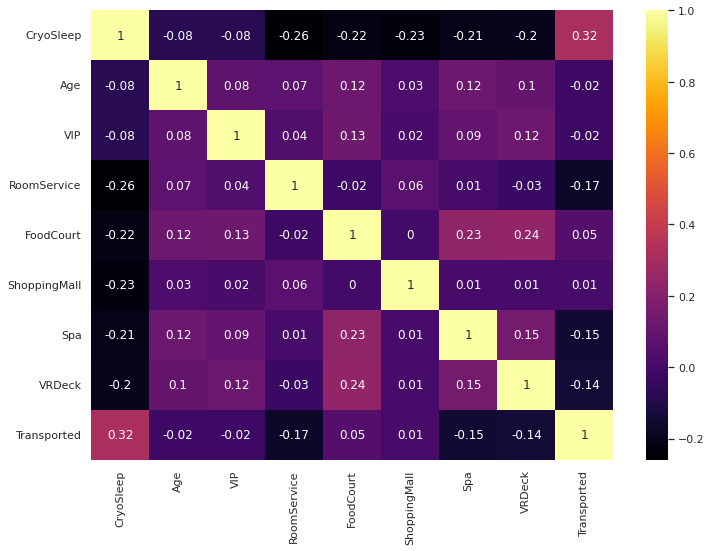

In [58]:
DF1_CORR = merged_all_DS.corr().round(2)
DF1_CORR
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.heatmap(DF1_CORR, annot=True, cmap='inferno')

In [59]:
X_train_all_ds, X_test_all_ds, y_train_all_ds, y_test_all_ds = train_test_split(
    X_std_all_ds,y_all_ds,
     stratify=y_all_ds,
      test_size=0.1)

In [60]:
X_train_all_ds, X_val_all_ds, y_train_all_ds, y_val_all_ds = train_test_split(X_std_all_ds,y_all_ds, stratify=y_all_ds, test_size=0.1)

In [61]:
X_train.shape, X_val_all_ds.shape, y_train_all_ds.shape, y_val_all_ds.shape

((8772, 14), (975, 14), (8772,), (975,))

In [62]:
C_values = [10.0**x for x in np.arange(-3, -1
                                       , 0.5)]
train_errs = list()
test_errs = list()

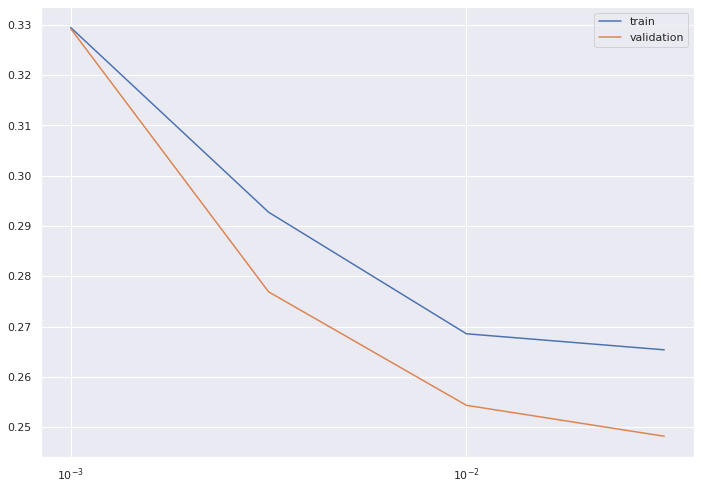

In [63]:
for C_value in C_values:
  lr = LogisticRegression(penalty="l1", C=C_value, solver='liblinear')
  lr.fit(X_train, y_train)

# Policzmy błąd:
#   score(X, y[, sample_weight])  Return the mean accuracy on the given test data and labels.
  train_errs.append(1.0 - lr.score(X_train_all_ds, y_train_all_ds))
  test_errs.append(1.0 - lr.score(X_test_all_ds, y_test_all_ds))

plt.semilogx(C_values, train_errs, C_values, test_errs)
plt.legend(("train", "validation"))
plt.show()

In [64]:
model_lr = LogisticRegression(random_state= 40, max_iter= 200, class_weight={0 : 0.33, 1: 0.67})

In [65]:
grid_parem_searcher = {'penalty' : ['l1'],
                       'C' : C_values,
                       'solver' : ['lbfgs', 'liblinear', 'saga'],
                       'max_iter' : [x*10 for x in range(1,5)]
                       }


In [66]:
searcher_lr = GridSearchCV(estimator=model_lr, param_grid=grid_parem_searcher, cv=5)
searcher_lr.fit(X_train, y_train)

/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number 

GridSearchCV(cv=5,
             estimator=LogisticRegression(class_weight={0: 0.33, 1: 0.67},
                                          max_iter=200, random_state=40),
             param_grid={'C': [0.001, 0.0031622776601683794, 0.01,
                               0.03162277660168379],
                         'max_iter': [10, 20, 30, 40], 'penalty': ['l1'],
                         'solver': ['lbfgs', 'liblinear', 'saga']})

In [67]:
searcher_lr.best_params_

{'C': 0.03162277660168379, 'max_iter': 10, 'penalty': 'l1', 'solver': 'saga'}

In [77]:
grid_pred_train = searcher_lr.predict(X_train_all_ds)
grid_pred_test = searcher_lr.predict(X_test_all_ds)

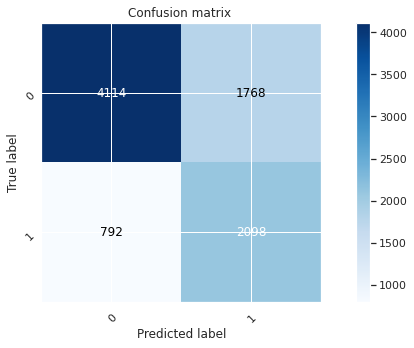

Results for TRAIN set with params
 {'C': 0.03162277660168379, 'max_iter': 10, 'penalty': 'l1', 'solver': 'saga'}
----
  Accuracy:  0.7081623347013224
  Precision: 0.7410834477936445
  Recall:    0.7081623347013224
  F1 score:  0.7160409720241048
  Mislabeled 2560 out of 8772




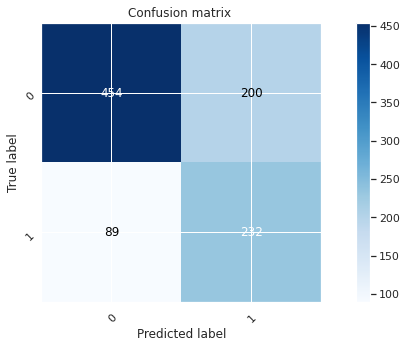

Results for TEST set with params
 {'C': 0.03162277660168379, 'max_iter': 10, 'penalty': 'l1', 'solver': 'saga'}
----
  Accuracy:  0.7035897435897436
  Precision: 0.7376364294596339
  Recall:    0.7035897435897436
  F1 score:  0.7116933819890415
  Mislabeled 289 out of 975




In [78]:
cm_y_pred_train = confusion_matrix(y_train_all_ds, grid_pred_train)
plt.show(plot_confusion_matrix(cm_y_pred_train, y_all_ds.unique()))

print_results(
    calculate_metrics(
        y_train_all_ds, grid_pred_train,
         average='weighted'),
         classifier_id=f'TRAIN set with params\n {searcher_lr.best_params_}')

cm_y_pred_test = confusion_matrix(y_test_all_ds, grid_pred_test)
plt.show(plot_confusion_matrix(cm_y_pred_test, y_all_ds.unique()))

print_results(
    calculate_metrics(
        y_test_all_ds, grid_pred_test,
         average='weighted'),
         classifier_id=f'TEST set with params\n {searcher_lr.best_params_}')